In [20]:
import pandas
import numpy
from os import path
from sklearn.model_selection import StratifiedKFold
from keras.layers import Conv2D, Conv1D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import MaxPooling1D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras import backend as K

In [2]:
def get_data(datadir, expdir, expnum):
    '''Creates data frames from a list of files.
    
    :param datadir
        The data directory containing the expriment directories.
    :param expdir
        A list of expriment directories.
    :param expnum
        The number of expriment trials per experiment.
    :return
        A list of data frames.
    '''
    assert datadir, 'datadir must name a path'
    assert expdir, 'expdir cannot be empty'
    assert expnum > 0, 'expnum must be greater than zero'
    dfs = []
    for ed in expdir:
        for n in range(1,expnum+1):
            filename = '{}-{}.csv'.format(ed, n)
            filepath = path.join(datadir, ed, filename)
            df = pandas.read_csv(filepath)
            dfs.append(df)
    return dfs

In [3]:
datadir = 'data/clean'
experiment_dirs = ['exp1', 'exp2', 'exp3']
experiment_trials = 5

dfs = get_data(datadir, experiment_dirs, experiment_trials)
df1 = dfs[0]

In [4]:
# The number of columns that will be the input for the neural net model
num_cols = len(df1.columns) - 2

# Look at the column
print(df1.columns)

Index(['rx', 'ry', 'rz', 'ax', 'ay', 'az', 'mx', 'my', 'mz', 'apprx', 'appry',
       'apprz', 'appax', 'appay', 'appaz', 'appmx', 'appmy', 'appmz',
       'incontext', 'nocontext'],
      dtype='object')


In [5]:
# Look at a small sample of the data
df1.head()

,rx,ry,rz,ax,ay,az,mx,my,mz,apprx,appry,apprz,appax,appay,appaz,appmx,appmy,appmz,incontext,nocontext
0,-0.114776,0.439484,-0.700906,-0.694898,1.077169,1.150464,0.073693,1.636875,0.559617,-1.858940,2.150135,-0.256785,-0.729854,0.786804,-0.229297,-1.041701,0.488485,0.869405,1,0
1,-0.178055,0.136300,-0.702962,-1.150445,0.410662,0.727458,0.073693,1.636875,0.559617,-1.597529,2.224365,-0.488612,0.005991,1.434085,-0.007593,-1.046289,0.472745,0.862275,1,0
2,-0.058157,0.161305,-0.709129,-0.919738,0.436072,1.006316,0.001939,1.712917,0.227799,-1.446922,1.882911,-0.719377,0.667759,1.362472,-0.043567,-1.019131,0.478037,0.818819,1,0
3,-0.607691,-0.657604,-0.657735,-1.256180,1.065773,0.232592,0.001939,1.712917,0.227799,-1.059426,1.048598,-0.818543,1.110339,0.871966,-0.317667,-0.992060,0.462353,0.760988,1,0
4,-0.544411,-1.017048,-0.672639,-0.430083,0.144706,-0.634227,0.001939,1.712917,0.227799,-0.345418,0.132309,-0.549512,0.980732,0.227001,-0.785198,-1.010228,0.446591,0.739677,1,0


In [6]:
def convert_to_input(dfs):
    '''Converts a list of data frames to a pair of lists of inputs and targets.
    
    :param dfs
        A list of data frames, where each data frame contains sensor readings from the PowerDue and PowerSense.
    :return
        A pair of lists (inputs, targets), where
        - each input in inputs is an array of the sensor readings for one experiment.
        - each target in targets is a vector of length two, where
          - [1, 0] represents a target where the PowerDue and mobile phone share context.
          - [0, 1] represents a target where the PowerDue and mobile phone do not share context.
    '''
    assert dfs, 'dfs cannot be empty'
    values = []
    targets = []
    cols = dfs[0].columns
    value_cols = cols[:-2]
    target_cols = cols[-2:]
    for df in dfs:
        value = df[value_cols].values
        target = df.iloc[0][target_cols].values
        values.append(value)
        targets.append(target)
    return values, targets     

inputs, targets = convert_to_input(dfs)
for i in range(0, len(inputs), 5):
    value, target = inputs[i], targets[i]
    print('The first row of the trial experiment %d' % i)
    print(value[0, :])
    print('The target for the trial experiment %d' %i)
    print(target)
    print()

The first row of the trial experiment 0
[-0.114776  0.439484 -0.700906 -0.694898  1.077169  1.150464  0.073693
  1.636875  0.559617 -1.85894   2.150135 -0.256785 -0.729854  0.786804
 -0.229297 -1.041701  0.488485  0.869405]
The target for the trial experiment 0
[ 1.  0.]

The first row of the trial experiment 5
[ 0.247633 -0.314106 -0.22799   0.399076  0.434287 -0.103136  0.182777
 -2.316515  4.607624  0.090366 -0.229647 -0.274152 -0.118235  0.070525
  0.065246 -2.501649 -1.409344  0.614023]
The target for the trial experiment 5
[ 0.  1.]

The first row of the trial experiment 10
[ 0.06957  -0.053842 -0.671361 -0.884662 -0.087146  0.641166  0.518448
 -1.077423  2.031714 -0.244218  0.235017  0.184547 -0.378222  0.101676
 -0.034164  3.003549 -2.023913 -1.924938]
The target for the trial experiment 10
[ 0.  1.]



In [16]:
def normalize_rows(data):
    '''Normalizes the rows in data by making them have the same number of rows.
    
    The number of rows that for each array will be the average number of rows.
    If an array has less rows then needed, then the last row is repeated until
    the array has the correct number of rows. If the array has more rows than
    needed, then the last rows are dropped.
    
    :param data
        A list of arrays
    :return
        A list of arrays with the same number of rows.
    '''
    assert len(data) != 0, 'cannot divide by zero'
    rows_mean = int(sum(arr.shape[0] for arr in data) / len(data))
    new_data = []
    for arr in data:
        rows = arr.shape[0]
        if rows > rows_mean:
            new_data.append(arr[:rows_mean, :])
        elif rows < rows_mean:
            diff_rows = rows_mean - rows
            # Repeat the last row
            arr_repeat = numpy.tile(arr[-1,:], (diff_rows, 1))
            new_arr = numpy.append(arr, arr_repeat, axis=0)
            new_data.append(new_arr)
        else:
            new_data.append(arr)
    return new_data

# Verify that all arrays have same number of rows
norm_rows_data = normalize_rows(inputs)
rows_num = norm_rows_data[0].shape[0]
assert all(rows_num == arr.shape[0] for arr in norm_rows_data), \
    'not all arrays have the same number of rows'
print('All arrays have {} rows'.format(rows_num))

All arrays have 2431 rows


In [22]:
def reshape_data(data):
    '''Reshapes 2d arrays into 3d arrays.
    
    :param data
        A list of 2d numpy arrays
    :return
        A list of 3d numpy arrays and a tuple of input parameters that can be fed to a Keras layer.
    '''
    new_data = numpy.array(data)
    samples, rows, cols = new_data.shape
    if K.image_data_format() == 'channels_first':
        new_data = new_data.reshape(samples, 1, rows, cols)
        input_shape = (1, rows, cols)
    else:
        new_data = new_data.reshape(samples, rows, cols, 1)
        input_shape = (rows, cols, 1) 
    return input_shape, new_data

input_shape, xform_data = reshape_data(norm_rows_data)
print('xform_data.shape:', xform_data.shape)
print('input_shape:', input_shape)

xform_data.shape: (15, 2431, 18, 1)
input_shape: (2431, 18, 1)


In [35]:
def create_model(input_shape):
    '''Creates an uncompiled neural net model.
    
    :return
        An uncompiled neural net model.
    '''
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model

In [36]:
arr_targets = numpy.array(targets)
arr_inputs = xform_data

In [37]:
# Compile the neural net
nsamples = arr_inputs.shape[0]
seed = 7
numpy.random.seed(seed)
zeros = numpy.zeros(nsamples)
# Leave one out k-fold cross validation
kfold = StratifiedKFold(n_splits=nsamples, shuffle=True, random_state=seed)
scores = []
for train, test in kfold.split(zeros, zeros):
    model = create_model(input_shape)
    # Compile model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    train_inputs = arr_inputs[train]
    train_targets = arr_targets[train]
    model.fit(train_inputs, train_targets, epochs=20, batch_size=10, verbose=0)
    test_input = arr_inputs[test]
    test_target = arr_targets[test]
    score_tuple = model.evaluate(test_input, test_target, verbose=0)
    score = int(score_tuple[1])
    print('score=', score_tuple, 'GUESSED RIGHT!!!' if score else 'WRONG!!!')
    scores.append((test[0], score))

score= [1.1920930376163597e-07, 1.0]
acc: 100.00%
score= [1.1920930376163597e-07, 1.0]
acc: 100.00%
score= [1.1920930376163597e-07, 1.0]
acc: 100.00%
score= [16.118095397949219, 0.0]
acc: 0.00%
score= [1.1920930376163597e-07, 1.0]
acc: 100.00%
score= [16.118095397949219, 0.0]
acc: 0.00%
score= [16.118095397949219, 0.0]
acc: 0.00%
score= [1.1920930376163597e-07, 1.0]
acc: 100.00%
score= [1.1920930376163597e-07, 1.0]
acc: 100.00%
score= [16.118095397949219, 0.0]
acc: 0.00%
score= [16.118095397949219, 0.0]
acc: 0.00%
score= [16.118095397949219, 0.0]
acc: 0.00%
score= [0.029746450483798981, 1.0]
acc: 100.00%
score= [1.1920930376163597e-07, 1.0]
acc: 100.00%
score= [16.118095397949219, 0.0]
acc: 0.00%


In [41]:
# See which experiment trials are predicted correctly (i.e., second element is 1)
scores.sort()
print('Scores:', scores)
correct = sum(guess for _, guess in scores)
print('Guessed {}/{} correct'.format(correct, len(scores)))

Scores: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0)]
Guessed 0/15 correct


In [42]:
# Gather results to plot predictions against actual data

x = list(range(1,len(scores)+1))

y_hat, y = [], []
for i, s in scores:
    if i < 5:
        actual = 1
        guess = 1 if s else 0
    else:
        guess = 0 if s else 1
        actual = 0
    y_hat.append(guess)
    y.append(actual)
    
y = x
y_hat = x

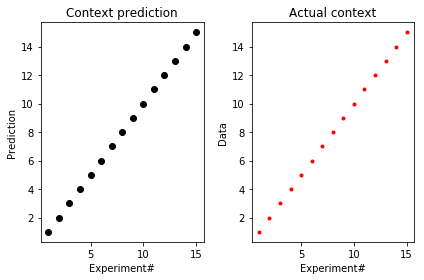

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(x, y_hat, 'ko')
plt.title('Context prediction')
plt.xlabel('Experiment#')
plt.ylabel('Prediction')

plt.subplot(1, 2, 2)
plt.plot(x, y, 'r.')
plt.title('Actual context')
plt.xlabel('Experiment#')
plt.ylabel('Data')

plt.tight_layout()
plt.show()